### Get and Clean the Data

Get the data in clean, standard format for further analysis
Different type of analysis require different format. Mainly, we need to get the following:
1. Corpus of text 
2. Document Term Matrix

Specifically, we'll be walking through:

1. **Getting the data - **in this case, we have our dataset from Kaggle
2. **Cleaning the data - **we will walk through popular text pre-processing techniques
3. **Organizing the data - **we will organize the cleaned data into a way that is easy to input into other algorithms

The output of this notebook will be clean, organized data in two standard text formats:

1. **Corpus** - a collection of text
2. **Document-Term Matrix** - word counts in matrix format

In [149]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
#with open(path_df, 'rb') as data:
df = pd.read_csv("./Hotel_Reviews.csv")

In [151]:
df.head()

Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No Negative   
2           Australia    Rooms are nice but for elderly a bit difficul...   
3      United Kingdom    My room was dirty and I was afraid to walk ba...   
4         New Zealand    You When I booked with your company on line y...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   
2                                 42                     1403   
3                                210                     1403   
4                                140                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   
2                                 21   
3                                 26   
4                                  8   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   
1                                           7             7.5   
2                                           9             7.1   
3                                           1             3.8   
4                                           3             6.7   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
2  [' Leisure trip ', ' Family with young childre...            3 days   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...            3 days   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...           10 days   

         lat       lng  
0  52.360576  4.915968  
1  52.360576  4.915968  
2  52.360576  4.915968  
3  52.360576  4.915968  
4  52.360576  4.915968

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

#### As a quick exploration of data, we plot the number of hotels versus their average rating:

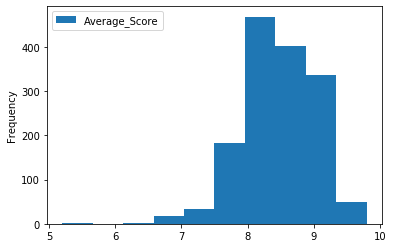

In [153]:
dfplot = df[["Hotel_Name","Average_Score"]].drop_duplicates()
df2 = dfplot.plot.hist()
plt.show()

* ***most ratings are between 7.6 and 9.2***

In [154]:
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

6.0
4.0


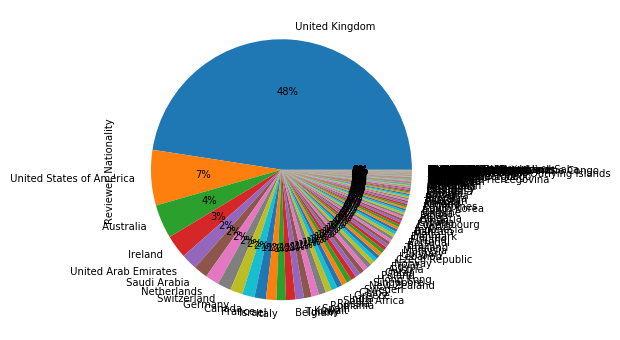

In [155]:
df.Reviewer_Nationality.value_counts().plot(kind='pie', autopct='%1.0f%%')

### Cleaning The Data

When dealing with numerical data, data cleaning often involves removing null values and duplicate data, dealing with outliers, etc. 
With text data, there are some common data cleaning techniques, which are also known as text pre-processing techniques.

With text data, this cleaning process can go on forever. There's always an exception to every cleaning step. So, we're going to follow the MVP (minimum viable product) approach - start simple and iterate. 
We're going to execute just the common cleaning steps here and the rest can be done at a later point to improve our results.

Common data cleaning steps on all text:

Make text all lower case
Remove punctuation
Remove numerical values
*Remove common non-sensical text (/n)
*Tokenize text
*Remove stop words

In [156]:
### Checking Missing values in the Data Set and printing the Percentage for Missing Values for Each Columns ###

count = df.isnull().sum().sort_values(ascending=False)
percentage = ((df.isnull().sum()/len(df)*100)).sort_values(ascending=False)
missing_data = pd.concat([count, percentage], axis=1, keys = ['Count','Percentage'])


In [157]:
# append the positive and negative text reviews
df["review"] =  df["Negative_Review"] +  df["Positive_Review"]
df["review"].head()

0     I am so angry that i made this post available...
1    No Negative No real complaints the hotel was g...
2     Rooms are nice but for elderly a bit difficul...
3     My room was dirty and I was afraid to walk ba...
4     You When I booked with your company on line y...
Name: review, dtype: object

## Sample the data

In [158]:
df = df.sample(frac = 0.1, replace = False, random_state=42)

In [159]:
df["review"].head()

488440     Would have appreciated a shop in the hotel th...
274649     No tissue paper box was present at the roomNo...
374688                  Pillows  Nice welcoming and service
404352    No Negative Everything including the nice upgr...
451596          No Negative Lovely hotel v welcoming staff 
Name: review, dtype: object

In [160]:
# remove 'No Negative' or 'No Positive' from text
df['Content_Parsed_1'] = df['review'].str.replace("No Positive", '')
df['Content_Parsed_1'] = df['review'].str.replace("No Negative", '')
df['Content_Parsed_1'].head()

488440     Would have appreciated a shop in the hotel th...
274649     No tissue paper box was present at the roomNo...
374688                  Pillows  Nice welcoming and service
404352     Everything including the nice upgrade The Hot...
451596                      Lovely hotel v welcoming staff 
Name: Content_Parsed_1, dtype: object

In [161]:
# Apply a first round of text cleaning techniques
#1. Text cleaning and preparation Removing new line and 
# \r and \n
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\r", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")

In [13]:
# remove 'No Negative' or 'No Positive' from text
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("No Positive", '')
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("No Negative", '')

In [162]:
# " when quoting text
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace('"', '')

In [163]:
# Lowercasing the text
df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()
df['Content_Parsed_2'].head()

488440     would have appreciated a shop in the hotel th...
274649     no tissue paper box was present at the roomno...
374688                  pillows  nice welcoming and service
404352     everything including the nice upgrade the hot...
451596                      lovely hotel v welcoming staff 
Name: Content_Parsed_2, dtype: object

In [164]:
punctuation_signs = list("?:!.,;")
df['Content_Parsed_3'] = df['Content_Parsed_2']

for punct_sign in punctuation_signs:
    df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(punct_sign, '')

In [165]:
df['Content_Parsed_4'] = df['Content_Parsed_3'].str.replace("'s", "")
df['Content_Parsed_4'].head()

488440     would have appreciated a shop in the hotel th...
274649     no tissue paper box was present at the roomno...
374688                  pillows  nice welcoming and service
404352     everything including the nice upgrade the hot...
451596                      lovely hotel v welcoming staff 
Name: Content_Parsed_4, dtype: object

In [179]:
df["review_clean"] = df['Content_Parsed_4']
df["review_clean"].head()

488440     would have appreciated a shop in the hotel th...
274649     no tissue paper box was present at the roomno...
374688                  pillows  nice welcoming and service
404352     everything including the nice upgrade the hot...
451596                      lovely hotel v welcoming staff 
Name: review_clean, dtype: object

In [180]:
# # Apply a second round of cleaning
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df["reviews"] = df["review_clean"].apply(lambda x: clean_text(x))

### Representing Text in Numeric Form

In [168]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

------------------------------------------------------------


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mbbal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mbbal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [184]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df["sentiments"] =df["reviews"].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

In [185]:
# add number of characters column
df["nb_chars"] = df["reviews"].apply(lambda x: len(x))

# add number of words column
df["nb_words"] = df["reviews"].apply(lambda x: len(x.split(" ")))

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51574 entries, 488440 to 273809
Columns: 3900 entries, Hotel_Address to compound
dtypes: float32(10), float64(3868), int64(7), object(15)
memory usage: 1.5+ GB


### Representing Text in Numeric Form

The next step consist in extracting vector representations for every review. The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks. What's interesting is that similar words will have similar representation vectors.

Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and that is why we can use those vectors as training features.

We first have to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, we can get those representation vectors.

In [187]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["reviews"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = df["reviews"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df], axis=1)

In [137]:
df.head()

Hotel_Address  \
235164  7 Gracechurch Street City of London London EC3...   
1550    1 2 Serjeant s Inn Fleet Street City of London...   
436343  Royal Victoria Dock Western Gateway Newham Lon...   
162865  36 rue du Grenier Saint Lazare 3rd arr 75003 P...   
165722  372 Strand Westminster Borough London WC2R 0JJ...   

        Additional_Number_of_Scoring Review_Date  Average_Score  \
235164                           764   2/22/2016            8.2   
1550                             639  10/24/2016            9.2   
436343                           879   6/28/2016            8.8   
162865                            28    6/5/2016            8.8   
165722                          2288  11/30/2015            8.1   

                             Hotel_Name Reviewer_Nationality  \
235164  Club Quarters Hotel Gracechurch      United Kingdom    
1550            Apex Temple Court Hotel      United Kingdom    
436343    Crowne Plaza London Docklands      United Kingdom    
162865                  Hotel Georgette      United Kingdom    
165722              Strand Palace Hotel      United Kingdom    

                                          Negative_Review  \
235164   I couldn t get a glass of wine at 10 15 on a ...   
1550                                          No Negative   
436343   When I asked how to pay for the congestion ch...   
162865                              Room could be bigger    
165722   the room were nice but not up to the same Sta...   

        Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
235164                                 16                     2996   
1550                                    0                     2619   
436343                                 47                     2768   
162865                                  6                      307   
165722                                 16                     9568   

                                          Positive_Review  ...  word_worth  \
235164   Comfy beds good location pleasant staff Great...  ...         0.0   
1550                     Super been before would go again  ...         0.0   
436343                                        No Positive  ...         0.0   
162865   Perfect location Spotless cleaning Very nice ...  ...         0.0   
165722   The hotel was lovely particularly reception b...  ...         0.0   

        word_would  word_write word_wrong word_yard  word_year  word_yes  \
235164    0.000000         0.0        0.0       0.0        0.0       0.0   
1550      0.458383         0.0        0.0       0.0        0.0       0.0   
436343    0.000000         0.0        0.0       0.0        0.0       0.0   
162865    0.000000         0.0        0.0       0.0        0.0       0.0   
165722    0.000000         0.0        0.0       0.0        0.0       0.0   

       word_yet word_young word_zone  
235164      0.0        0.0       0.0  
1550        0.0        0.0       0.0  
436343      0.0        0.0       0.0  
162865      0.0        0.0       0.0  
165722      0.0        0.0       0.0  

[5 rows x 3734 columns]

In [188]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df['reviews']).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)

In [189]:
df['reviews']

488440    would appreciate shop hotel sell drinking wate...
274649             tissue paper box present roomno positive
374688                          pillow nice welcome service
404352    everything include nice upgrade hotel revamp s...
451596                           lovely hotel welcome staff
                                ...                        
274862    bathroom water easy make bathroom wet bath wal...
9732                   room small chair tatty room positive
424201    expensive rate mini bar price roof top pool vi...
72380     loud ac machine right outside window affect sl...
273809    definitely stars hotel location good hotel req...
Name: reviews, Length: 51574, dtype: object

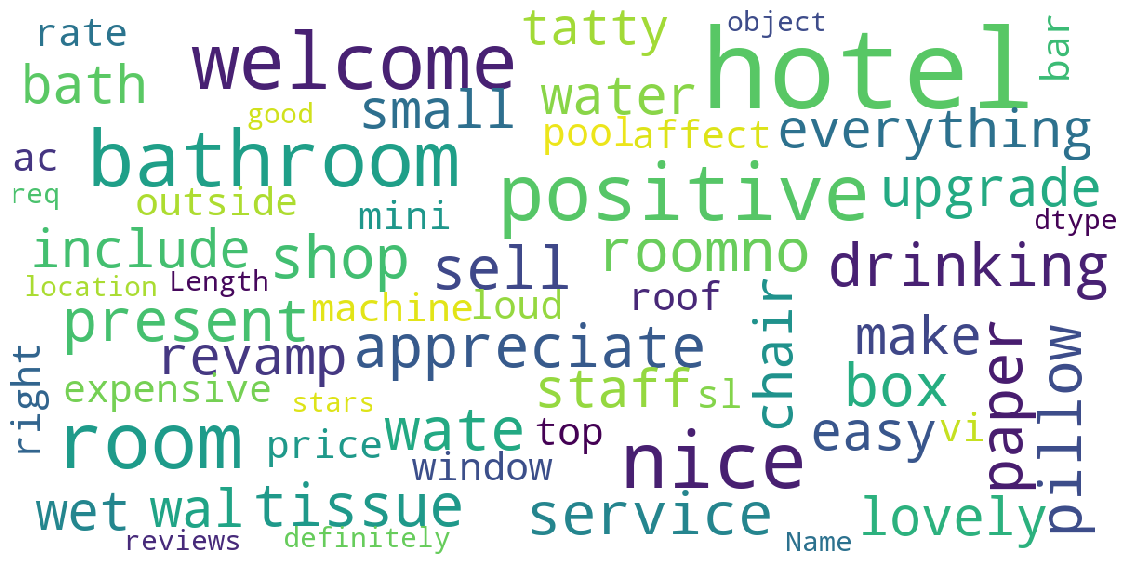

In [190]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 500,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df["reviews"])

Most of the words are indeed related to the hotels: room, location, breakfast, etc. Some words are more related to the customer experience with the hotel stay: perfect, loved, expensive, dislike, etc.

In [192]:
# highest positive sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("pos", ascending = False)[["reviews", "pos"]].head(10)

ValueError: The column label 'pos' is not unique.

In [144]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review_clean", "neg"]].head(10)

ValueError: The column label 'pos' is not unique.

In [31]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [32]:
# nrows = len(df)
# lemmatized_text_list = []

# for row in range(0, nrows):
    
#     # Create an empty list containing lemmatized words
#     lemmatized_list = []
    
#     # Save the text and its words into an object
#     text = df.loc[row]['Content_Parsed_4']
#     text_words = text.split(" ")

#     # Iterate through every word to lemmatize
#     for word in text_words:
#         lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
#     # Join the list
#     lemmatized_text = " ".join(lemmatized_list)
    
#     # Append to the list containing the texts
#     lemmatized_text_list.append(lemmatized_text)

In [34]:
# df['Content_Parsed_5'] = lemmatized_text_list
# df['Content_Parsed_5'].head()

* **NOTE:** This data cleaning aka text pre-processing step could go on for a while, but we are going to stop for now. After going through some analysis techniques, and will not see any good result. Then, we can go back and proceed with more data cleaning like the following below:

* Mark 'calling' and 'call' as the same word (stemming / lemmatization)
* Combine 'thank you' into one term (bi-grams)
* And a lot more...

### Tokenization

Tokenize the text – split text into smaller pieces, most common token size is a word, can also be a sentence. 
Aplit text into smaller pieces, Tokenization means every word is its own file/token

In [35]:
##Stop Words# Downloading the stop words list
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mbbal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
# Loading the stop words in english
stop_words = list(stopwords.words('english'))

In [58]:
stop_words[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [59]:
df['Content_Parsed_5'] = df['Content_Parsed_4']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df = df['Content_Parsed_6'].str.replace(regex_stopword, '')

KeyError: 'Content_Parsed_6'

In [29]:
df.head(3)

0     i am so angry that i made this post available...
1     no real complaints the hotel was great great ...
2     rooms are nice but for elderly a bit difficul...
Name: Content_Parsed_4, dtype: object

**NOTE:** After removing stop words, we now have a bag of words model. It’s a simple text format that ignores order
At this point, we could go on and create word clouds.

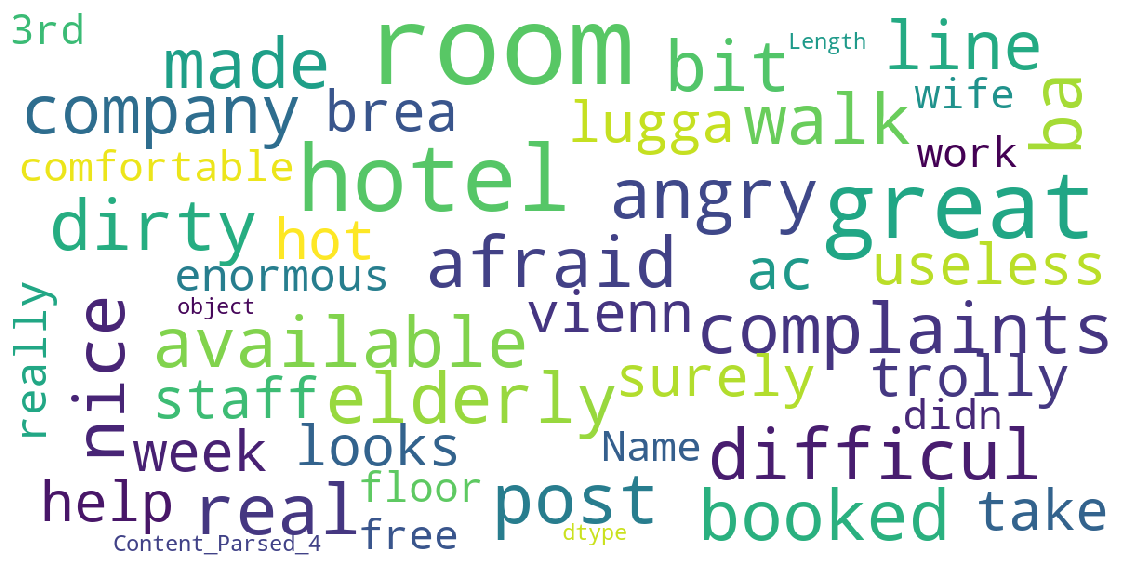

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud( df )

### Findings

* **Guest generally rate their hotel stays based on room and hotel staff**
* **Hotels should be more thoughtful about how people and technology, powered by insights, weave together to deliver authentic hospitality.**

### Side Note

In EDA, our goal is  **To be able to take an initial look at our data and see if the results of some basic analysis made sense.**

Conclusion - yes, it does, for a first pass. There are definitely some things that could be better cleaned up, such as adding more stop words or including bi-grams. But we can save that for another day. The results so far using word cloud are interesting and make general sense, so we're going to move on.

# Sentiment Analysis

At this point, all of the analysis we've done has been pretty generic - looking at wordcloud, plots, etc. These techniques could be applied to numeric data as well.
Analyzing huge text data can be a daunting task not to mention time-consuming and expensive. Sentiment analysis, helps businesses make sense of all this unstructured text by automatically tagging it.

1. **TextBlob Module:** Linguistic researchers have labeled the sentiment of words based on their domain expertise. Sentiment of words can vary based on where it is in a sentence. The TextBlob module allows us to take advantage of these labels.
2. **Sentiment Labels:** Each word in a corpus is labeled in terms of polarity and subjectivity (there are more labels as well, but we're going to ignore them for now). A corpus' sentiment is the average of these.
   * **Polarity**: How positive or negative a word is. -1 is very negative. +1 is very positive.
   * **Subjectivity**: How subjective, or opinionated a word is. 0 is fact. +1 is very much an opinion.!

In [188]:
# We'll start by reading in the corpus, which preserves word order

data = df['Content_Parsed_4']
data.head()

0     i am so angry that i made this post available...
1     no real complaints the hotel was great great ...
2     rooms are nice but for elderly a bit difficul...
3     my room was dirty and i was afraid to walk ba...
4     you when i booked with your company on line y...
Name: Content_Parsed_4, dtype: object

In [191]:
data.to_pickle("dtm.pkl")

In [33]:
df.info()

AttributeError: 'Series' object has no attribute 'info'

In [34]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df['polarity'] = df.apply(pol)
df['subjectivity'] = df.apply(sub)
df.head()

TypeError: The `text` argument passed to `__init__(text)` must be a string, not <class 'pandas.core.series.Series'>

In [1]:
# Let's plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, nationality in enumerate(df.index):
    x = df.polarity.loc[nationality]
    y = df.subjectivity.loc[nationality]
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, df['Reviewer_Nationality'][index], fontsize=10)
    plt.xlim(-.01, .12) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

NameError: name 'df' is not defined

In [138]:
df.head()

Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No Negative   
2           Australia    Rooms are nice but for elderly a bit difficul...   
3      United Kingdom    My room was dirty and I was afraid to walk ba...   
4         New Zealand    You When I booked with your company on line y...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   
2                                 42                     1403   
3                                210                     1403   
4                                140                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   
2                                 21   
3                                 26   
4                                  8   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   
1                                           7             7.5   
2                                           9             7.1   
3                                           1             3.8   
4                                           3             6.7   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
2  [' Leisure trip ', ' Family with young childre...            3 days   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...            3 days   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...           10 days   

         lat       lng  
0  52.360576  4.915968  
1  52.360576  4.915968  
2  52.360576  4.915968  
3  52.360576  4.915968  
4  52.360576  4.915968

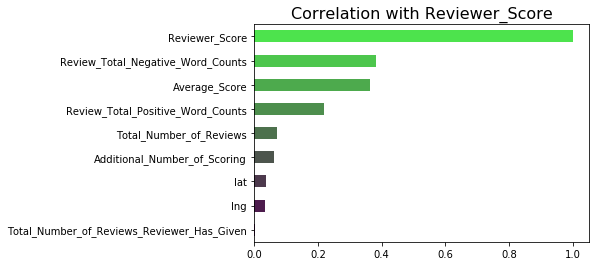

In [136]:
df_corr = df.corr()

# Get the colors for the graphic
colors = []
dim = df_corr.shape[0]
for i in range(dim):
    r = i * 1/dim
    colors.append((0.3,r,0.3))

# Transform each value in a positive value, because what interesses us
# isn't the direction of the correlation but the absolute correlation
df_corr["Reviewer_Score"].apply(lambda x: abs(x)).sort_values().plot.barh(color = colors)
plt.title("Correlation with Reviewer_Score", fontsize = 16)
plt.show()

In [151]:
# Columns to use to train the models
# Only the columns with the highest correlation were chosen
cols = ['Review_Total_Negative_Word_Counts',
        'Total_Number_of_Reviews',
        'Average_Score',
        'Review_Total_Positive_Word_Counts']
        
X = df[cols].values
y = df["Reviewer_Score"].values

In [141]:
import seaborn as sns

In [142]:
# Use StandardScaler to scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [149]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.metrics import mean_squared_error

def plot_res(y_test,pred, model = "LinearRegression"):
# Violinplots with the distribution of real scores and predicted scores

    MSRE = round((mean_squared_error(y_test,pred))**0.5,3)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
    
    sns.violinplot(y_test, ax = axes[0])
    axes[0].set_title("Distribution of\n scores")
    axes[0].set_xlim(0,11)
    
    sns.violinplot(pred, ax = axes[1])
    title = f"Predictions of scores with {model}\nMSRE:{MSRE}"
    axes[1].set_title(title)
    axes[1].set_xlim(0,11)
    plt.show()
    

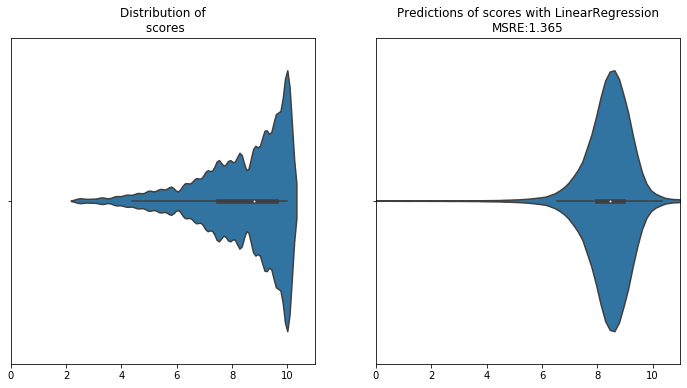

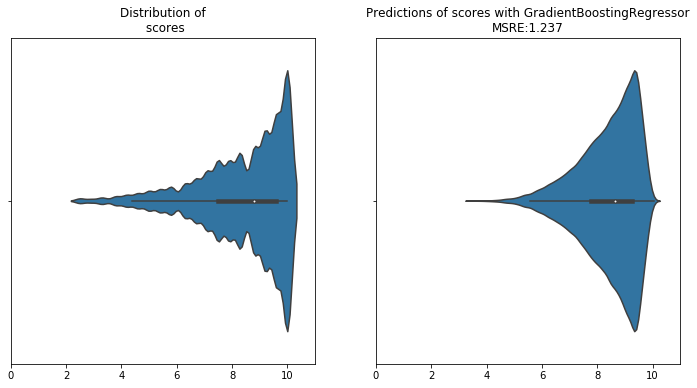

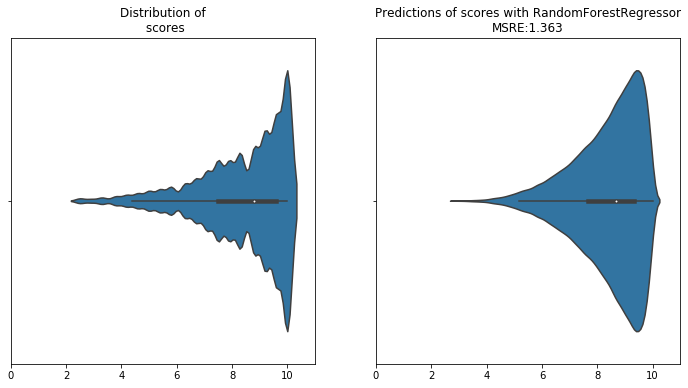

In [150]:
# LinearRegression
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
plot_res(y_test,pred, model = "LinearRegression")

# GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
plot_res(y_test,pred, model = "GradientBoostingRegressor")

# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
plot_res(y_test,pred, model = "RandomForestRegressor")


Gradient boosting is the best prediction model for average scores